# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **rail.rail_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/JaimeRZP/pacc) for sacc files.

In [1]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
import qp
import sacc
import yaml

import rail.rail_prior as rail_prior
import pacc

### Load Data

In [2]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

# Ensembles
source_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_0.npz', allow_pickle=True)
source_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_1.npz', allow_pickle=True)
source_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_2.npz', allow_pickle=True)
source_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_3.npz', allow_pickle=True)
source_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/shear_4.npz', allow_pickle=True)

lens_0 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_0.npz', allow_pickle=True)
lens_1 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_1.npz', allow_pickle=True)
lens_2 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_2.npz', allow_pickle=True)
lens_3 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_3.npz', allow_pickle=True)
lens_4 = np.load('/home/jaimerz/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs/lens_4.npz', allow_pickle=True)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

In [3]:
#cle = pacc.ClsEnsemble(s, y, label="CosmoDC2")
#pacc.plot_cls([cle], cle.pairs)

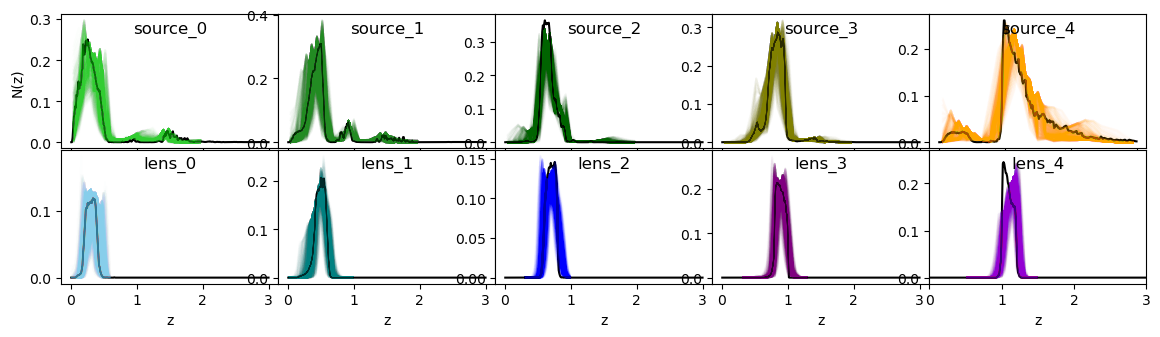

In [4]:
figure, axis = plt.subplots(2, 5, figsize=(14, 3.5))
figure.subplots_adjust(wspace=0, hspace=0.01)

colors = ['limegreen', 'forestgreen', 'darkgreen', 'olive', 'orange']
lens_keys = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[0, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[0, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[0].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[0, i].set_title(key, y=0.8)
    axis[0, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

colors = ['skyblue', 'teal', 'blue', 'purple', 'darkviolet']
lens_keys = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, key in enumerate(lens_keys):
    tomo = tomos[key]
    spec = s.tracers[key]
    photo_dz = np.mean(np.diff(tomo['znodes']))
    spec_dz = np.mean(np.diff(spec.z))
    alpha = photo_dz/spec_dz
    norm = np.sum(np.mean(tomo['photo_hists'], axis=1))
    axis[1, i].plot(spec.z, alpha*spec.nz, 'k-')
    axis[1, i].plot(tomo['znodes'], tomo['photo_hists']/norm, '-', color=colors[i], alpha=0.01)
    #axis[1].plot(tomo['spec_zgrid'], alpha*tomo['photo_fid'], '-', color=colors[i], label=key)
    axis[1, i].set_title(key, y=0.8)
    axis[1, i].set_xlabel('z')
    if i == 0:
        axis[0, i].set_ylabel('N(z)')

#nzsum = np.sum(fz_df['pdf'])
#plt.plot(zgrid,nzsum,c='b',label=f"i<{magcut} sum p(z)")

plt.xlim([0.0, 3.0])
plt.show()

In [5]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        tomo = tracers_dict[key]
        nzs = tomo['photo_hists']
        zs = tomo['znodes']
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

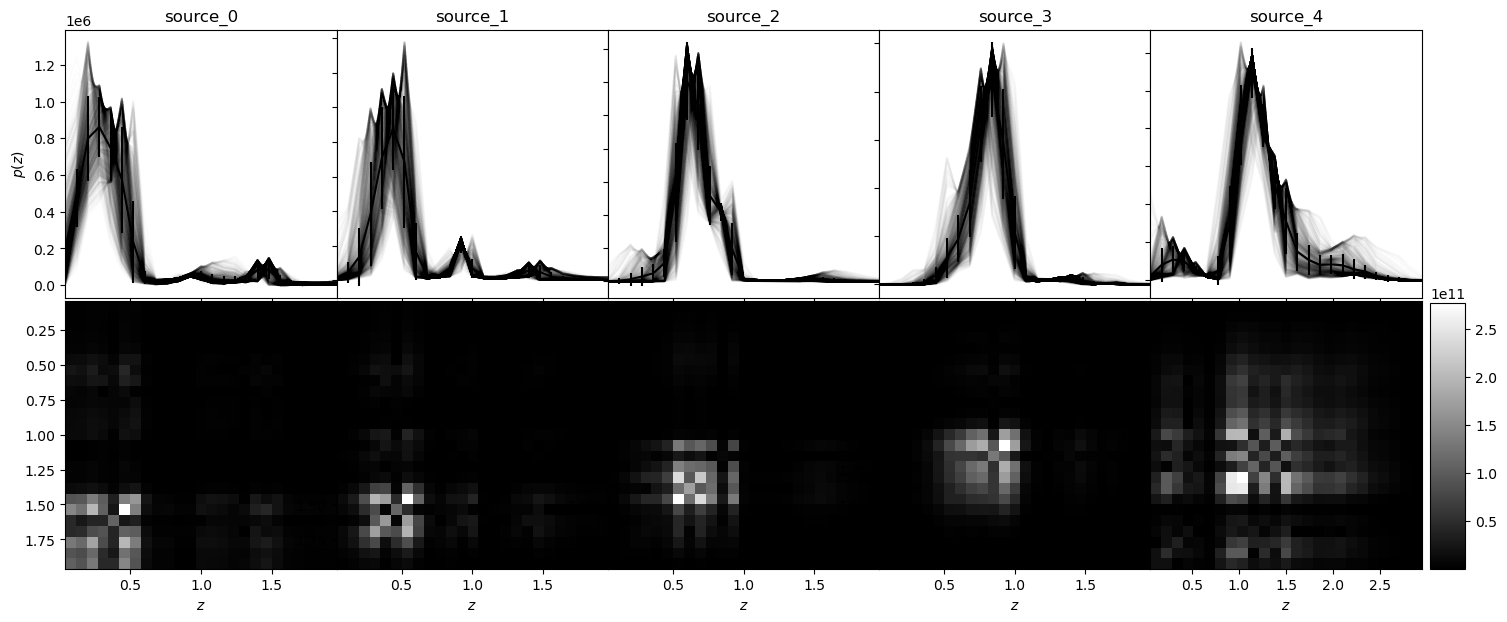

In [6]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(tomos, plot_tracers)

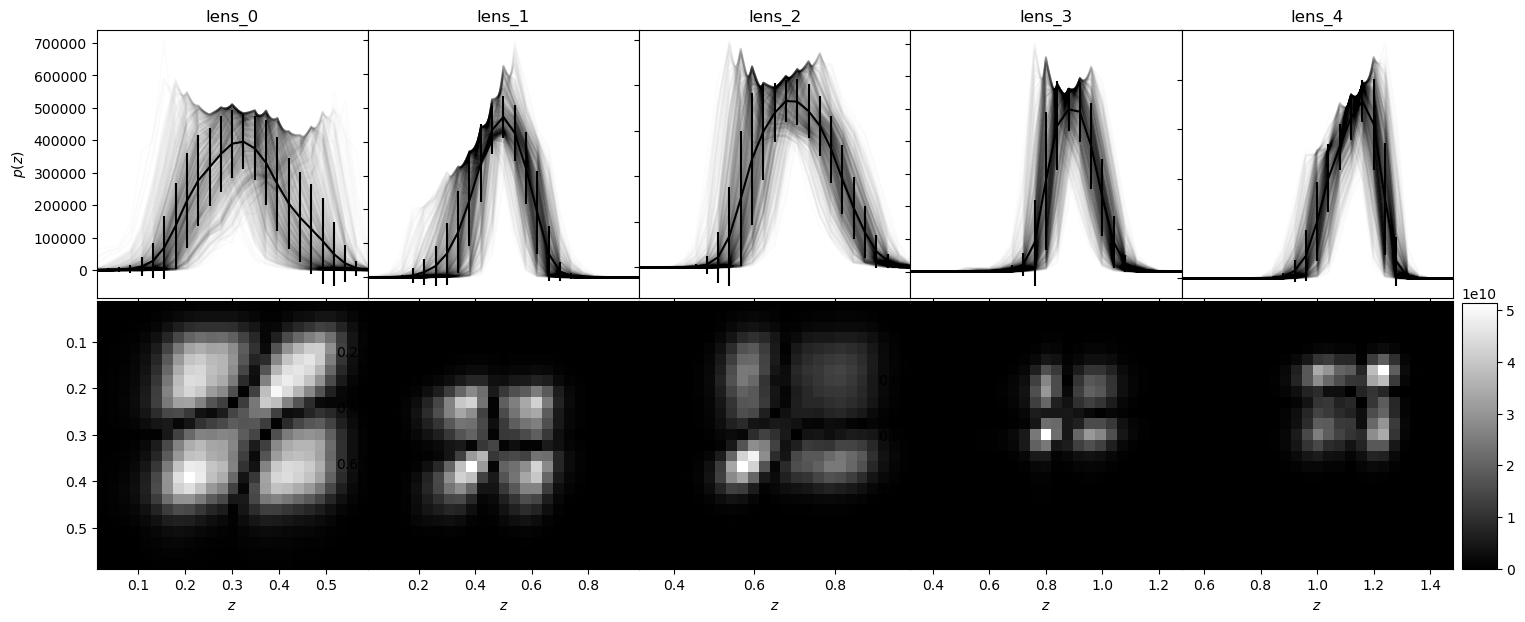

In [7]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(tomos, plot_tracers)

# Interfacing SACC and QP

In [8]:
def make_qp(ens):
    pzs = ens['photo_hists'].T
    zs_edges = ens['zgrid']
    return qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        ens = enss[key]
        q = make_qp(ens)
        ss.add_tracer('Qpnz', key, q)
    return ss

ss_qp = update_sacc_qp(s, tomos)

# Computing Uncertainties

Now we are just going to apply the methods of rail_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [9]:
shifts = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    shift_obj = rail_prior.PriorShifts(ens)
    shifts[tracer] = shift_obj
    shift = shift_obj.get_prior()
    print(shift)


source_0
(array([-2.02268757e-16]), array([[1.30133883e-32]]))
source_1
(array([1.43635104e-16]), array([[1.46977344e-32]]))
source_2
(array([-3.80077914e-16]), array([[1.4520278e-32]]))
source_3
(array([-2.42861287e-17]), array([[1.40953998e-32]]))
source_4
(array([2.15452656e-16]), array([[3.1309482e-32]]))
lens_0
(array([4.36109482e-17]), array([[1.23434174e-33]]))
lens_1
(array([3.30551558e-16]), array([[3.3649532e-33]]))
lens_2
(array([9.30245464e-17]), array([[5.87870367e-33]]))
lens_3
(array([-1.57512892e-16]), array([[8.9897595e-33]]))
lens_4
(array([-1.994932e-16]), array([[1.41285017e-32]]))


In [10]:
shifted_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    shift_obj = shifts[tracer]
    pz_fid = [shift_obj.z, shift_obj.nz_mean]
    model = shift_obj.evaluate_model
    shifted_nzs_tracer = np.array([model(pz_fid, shift_obj.sample_prior())[1] for i in range(1000)])
    shifted_nzs[tracer] = [shift_obj.z, shifted_nzs_tracer.T]


source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


In [11]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        zs, nzs = tracers_dict[key]
        axis[0,i].plot(zs, nzs, 'k-', alpha=0.01)
        cov = np.cov(nzs)
        nz_mean = np.mean(nzs, axis=1)
        #axis[0,i].errorbar(zs, nz_mean, yerr=np.sqrt(np.diag(cov)), fmt='k-')
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_title(key)
        axis[0,i].set_ylim([-0.01, 0.35])
        if i == 0:
            axis[0,i].set_ylabel(r'$p(z)$')
        else:
            axis[0,i].set_yticklabels([])
        im = axis[1,i].imshow(abs(cov), aspect='auto',
                            origin='lower', cmap='gray',
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

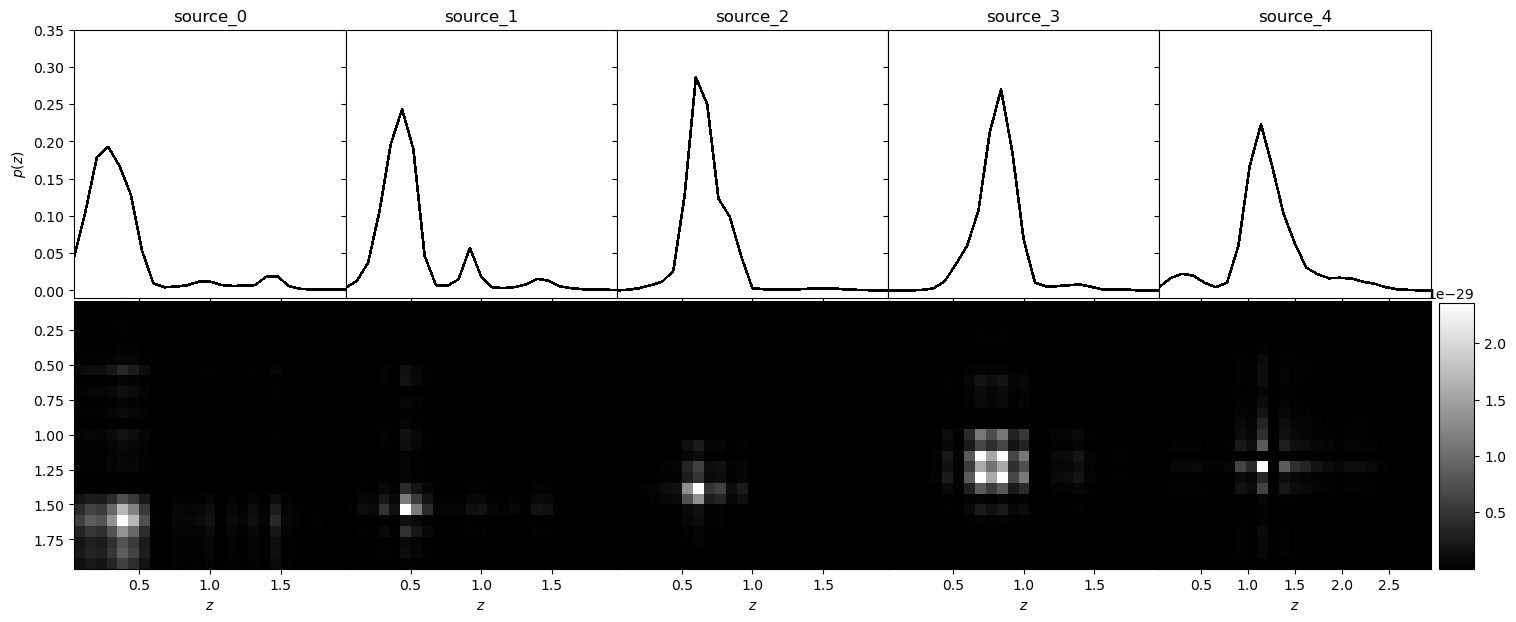

In [12]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(shifted_nzs, plot_tracers)

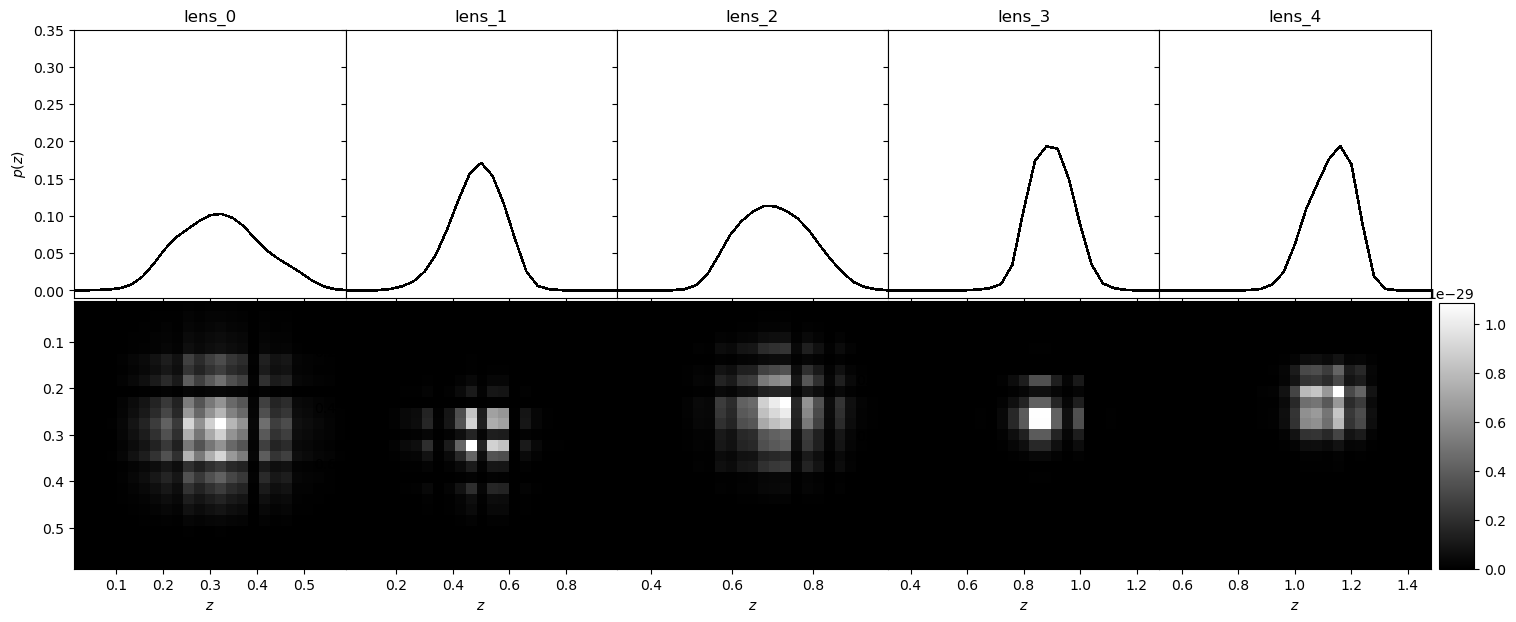

In [13]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(shifted_nzs, plot_tracers)

In [14]:
shifts["source_0"].get_prior()

(array([-2.02268757e-16]), array([[1.30133883e-32]]))

## Shifts & widths

In [15]:
SnWs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    snw_obj = rail_prior.PriorShiftsWidths(ens)
    SnWs[tracer] = snw_obj
    print(snw_obj.shift, snw_obj.width)

source_0
1.140762388212507e-16 0.08292112254090464
source_1
1.2123421287157841e-16 0.047024295382465504
source_2
1.2050011610703586e-16 0.024378840491880303
source_3
1.1872404887167587e-16 0.039510531950330226
source_4
1.7694485579987544e-16 0.0733445692635794
lens_0
3.513319999837971e-17 0.058231976195807646
lens_1
5.800821667268553e-17 0.07876384612261488
lens_2
7.667270487071068e-17 0.023500999646088653
lens_3
9.481434225850811e-17 0.01017767536832208
lens_4
1.1886337409565337e-16 0.04124182278211033


In [16]:
nzs = SnWs["source_0"].nzs
ms = [np.median(nz) for nz in nzs]
shift = np.mean(SnWs["source_0"].z)*np.std(ms)/np.mean(ms)
print(shift)

0.3907764018894434


In [17]:
snw_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    snw_obj = SnWs[tracer]
    pz_fid = [snw_obj.z, snw_obj.nz_mean]
    model = snw_obj.evaluate_model
    snw_nzs_tracer = np.array([model(pz_fid, snw_obj.sample_prior())[1] for i in range(1000)])
    snw_nzs[tracer] = [snw_obj.z, snw_nzs_tracer.T]


source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


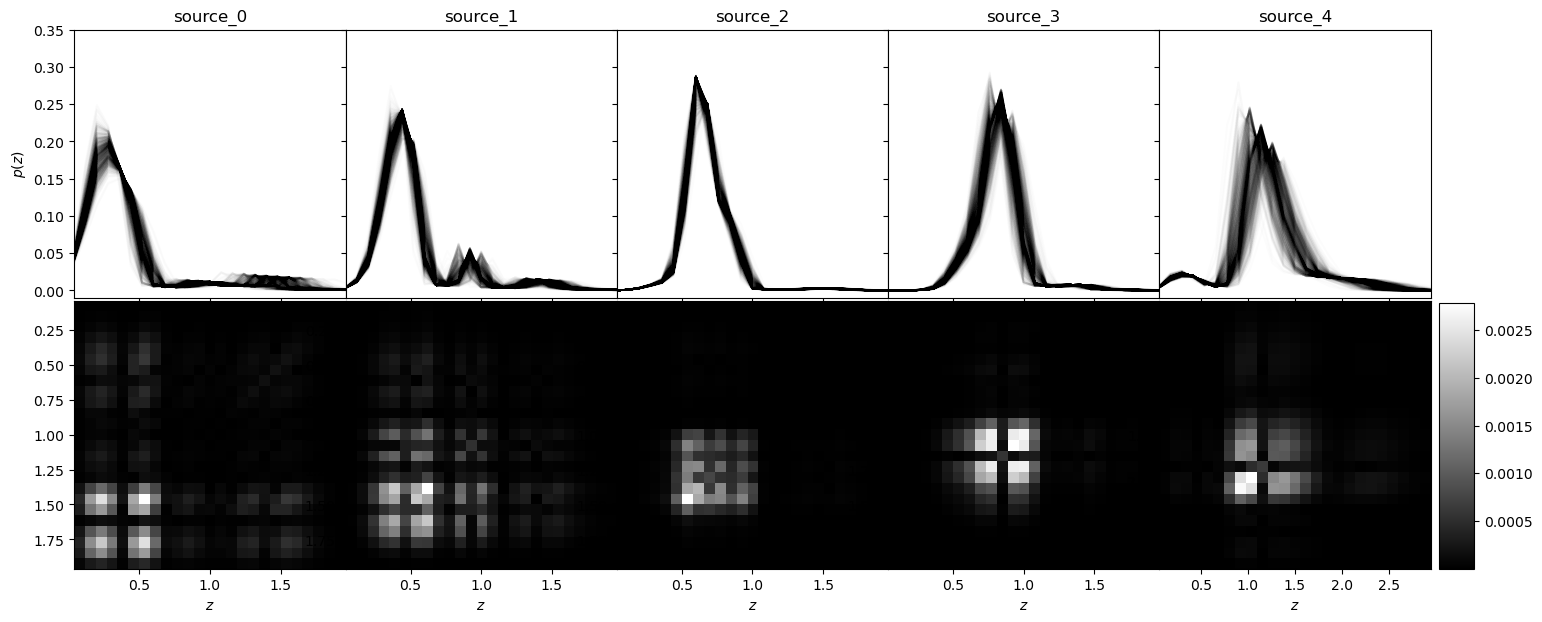

In [18]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(snw_nzs, plot_tracers)

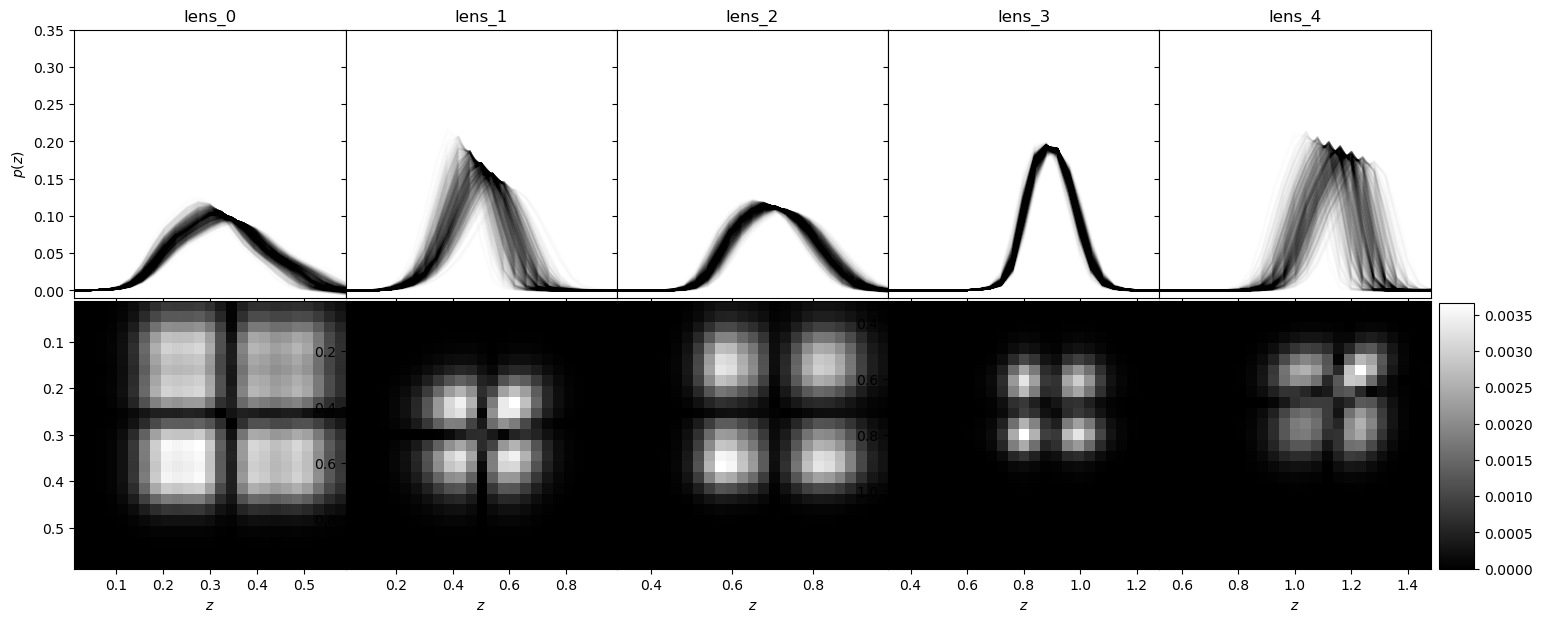

In [19]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(snw_nzs, plot_tracers)

In [20]:
SnWs['source_0'].get_prior()

(array([0, 1]),
 array([[1.30133883e-32, 0.00000000e+00],
        [0.00000000e+00, 6.87591256e-03]]))

## Moments

In [21]:
moments = {}
for tracer in ss_qp.tracers:
    print(tracer)
    ens = ss_qp.tracers[tracer].ensemble
    moment_obj = rail_prior.PriorMoments(ens)
    moments[tracer] = moment_obj

source_0
source_1
The covariance matrix will be regularized
source_2
source_3
The covariance matrix will be regularized
source_4
lens_0
lens_1
The covariance matrix will be regularized
lens_2
lens_3
The covariance matrix will be regularized
lens_4


In [22]:
moments_nzs = {}
for tracer in ss_qp.tracers:
    print(tracer)
    moments_obj = moments[tracer]
    pz_fid = [moments_obj.z, moments_obj.nz_mean]
    model = moments_obj.evaluate_model
    moments_nzs_tracer = np.array([model([pz_fid[0], moments_obj.sample_prior()])[1] for i in range(1000)])
    moments_nzs[tracer] = [moments_obj.z, moments_nzs_tracer.T]

source_0
source_1
source_2
source_3
source_4
lens_0
lens_1
lens_2
lens_3
lens_4


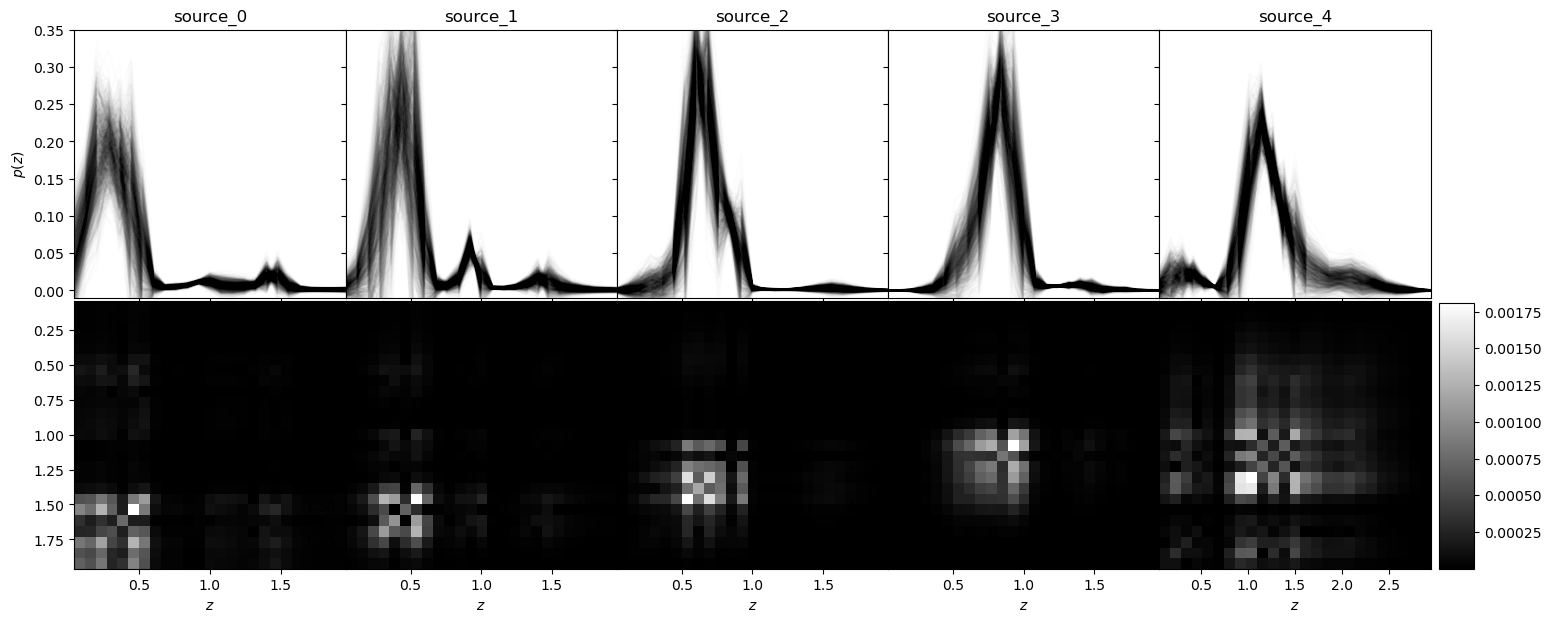

In [23]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(moments_nzs, plot_tracers)

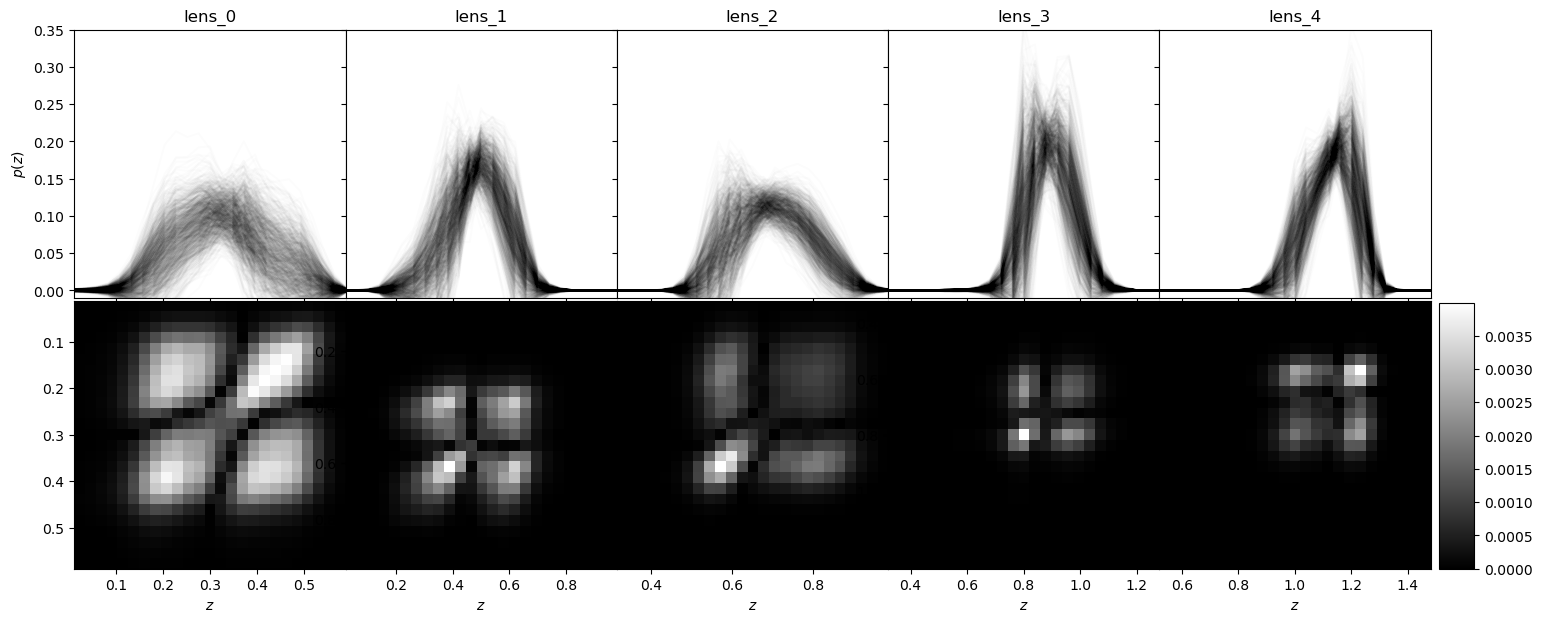

In [24]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(moments_nzs, plot_tracers)

In [25]:
moments['source_0'].get_prior()

(array([0.04585036, 0.10665211, 0.17891292, 0.19289311, 0.16716556,
        0.1288544 , 0.0532771 , 0.00947965, 0.00431763, 0.00512929,
        0.00699818, 0.01166119, 0.01207673, 0.00726737, 0.00609055,
        0.00615178, 0.00724937, 0.01865096, 0.01886819, 0.00566237,
        0.00211796, 0.00138231, 0.00113012, 0.0010655 , 0.00109529]),
 array([[ 1.59227141e-03,  1.37171187e-03,  1.95737987e-03,
          6.36054509e-04, -7.09318384e-04, -2.22933781e-03,
         -1.38514831e-03, -1.81372834e-04, -6.15162284e-05,
         -6.19148390e-05, -1.18564653e-05, -1.53826241e-05,
         -1.59374690e-04, -1.40429327e-04, -1.17938369e-04,
         -7.43555922e-05,  1.01302524e-04,  2.15009307e-04,
         -3.51440017e-04, -1.79410715e-04, -5.99174499e-05,
         -3.92965208e-05, -3.30313152e-05, -3.02152085e-05,
         -3.24727940e-05],
        [ 1.37171187e-03,  1.23848798e-03,  1.72094623e-03,
          6.71952205e-04, -4.26160016e-04, -1.88124154e-03,
         -1.45633787e-03, -2.00